# Test of PS_Fullmodel_1step by LBNL (Slimming level 1)

Setteing

In [1]:
from sample_algorithm.onestepSim_LBNL import runQuantum
circuit_LBNL1 = runQuantum(gLR=1,dophisplit=1)

In [2]:
from transpiler.optimization import slim
example1 = slim.circuit_optimization( circuit=circuit_LBNL1, slim_level=1, work_register = 'w', cut='high')
circuit_LBNL1_op = example1.slim()
circuit_LBNL1 = runQuantum(gLR=1,dophisplit=1)

In [3]:
from qiskit import(
  QuantumCircuit,
  execute,
  Aer)
from qiskit.visualization import plot_histogram

In [ ]:
from qiskit import IBMQ
from qiskit import *
IBMQ.load_account()
provider = IBMQ.get_provider(hub='your_account',group='your_account',project='your_account')
provider.backends(simulator=False)

In [5]:
qc = 'ibmq_sydney'

# Classical Simulator

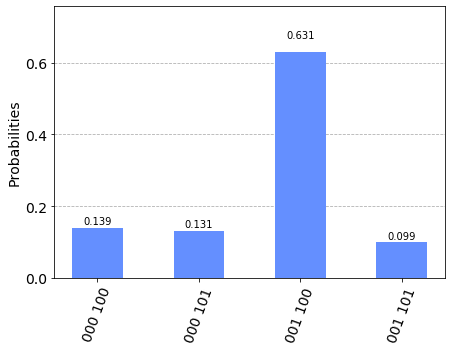

In [6]:
circuit=circuit_LBNL1
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit, simulator, shots=81920)
result = job.result()
counts = result.get_counts(circuit)

plot_histogram(counts,number_to_keep=None)

In [7]:
print(counts)

{'000 100': 11373, '000 101': 10732, '001 100': 51680, '001 101': 8135}


## Original

In [10]:
new_circ_lv3 = transpile(circuit_LBNL1, backend=backend, optimization_level=3)
        
for _ in range(10):
    candidate = transpile(circuit_LBNL1, backend=backend, optimization_level=3)
    if candidate.__len__() < new_circ_lv3.__len__():
        new_circ_lv3 = candidate
        
print(new_circ_lv3.depth(), ',', new_circ_lv3.__len__())
print('Gate counts:', new_circ_lv3.count_ops())

573 , 896
Gate counts: OrderedDict([('cx', 527), ('u2', 178), ('u1', 137), ('u3', 47), ('measure', 6), ('barrier', 1)])


## After slimming by new optimizer by CC

In [12]:
new_circ_lv3_op = transpile(circuit_LBNL1_op, backend=backend, optimization_level=3)
        
for _ in range(10):
    candidate = transpile(circuit_LBNL1_op, backend=backend, optimization_level=3)
    if candidate.__len__() < new_circ_lv3_op.__len__():
        new_circ_lv3_op = candidate
        
print(new_circ_lv3_op.depth(), ',', new_circ_lv3_op.__len__())
print('Gate counts:', new_circ_lv3_op.count_ops())

166 , 287
Gate counts: OrderedDict([('cx', 178), ('u2', 62), ('u3', 21), ('u1', 19), ('measure', 6), ('barrier', 1)])


##  tket (only slimming capacity)

In [13]:
from pytket.qiskit import qiskit_to_tk, tk_to_qiskit
from pytket.passes import (RemoveRedundancies, CommuteThroughMultis, CliffordSimp, RebaseIBM, O2Pass,
                           FullPeepholeOptimise, EulerAngleReduction, USquashIBM, SynthesiseIBM, PauliSimp,
                           GuidedPauliSimp, OptimisePhaseGadgets, SquashHQS, FlattenRegisters, KAKDecomposition,
                           RepeatPass, SequencePass)
from pytket import OpType

In [14]:
def passes2(circ_tk):
    pass_list=[EulerAngleReduction(OpType.Rz, OpType.Rx),
    RemoveRedundancies(),
    GuidedPauliSimp(),
    SquashHQS(),
    FlattenRegisters(),
    OptimisePhaseGadgets(),
    KAKDecomposition(),
    USquashIBM(),
    CliffordSimp(),
    FullPeepholeOptimise()]
    
    RebaseIBM().apply(circ_tk)
    CommuteThroughMultis().apply(circ_tk)
    
    circ_tk_qiskit_copy = tk_to_qiskit(circ_tk)
    circ_tk_copy = qiskit_to_tk(circ_tk_qiskit_copy)
    
    best_pass = RebaseIBM()
    mini = tk_to_qiskit(circ_tk).__len__()
    for a_pass in pass_list:
        #print(tk_to_qiskit(circ_tk_copy).__len__())
        a_pass.apply(circ_tk_copy)
        if circ_tk_copy.n_gates < mini :
            mini = circ_tk_copy.n_gates
            best_pass = a_pass
        circ_tk_qiskit_copy = tk_to_qiskit(circ_tk)
        circ_tk_copy = qiskit_to_tk(circ_tk_qiskit_copy)
        
    best_pass.apply(circ_tk)
        
    return circ_tk

### Before slimming

In [15]:
circ = circuit_LBNL1
mystate_reduct_tk = qiskit_to_tk(circ)
RebaseIBM().apply(mystate_reduct_tk)

while tk_to_qiskit(mystate_reduct_tk).__len__() != tk_to_qiskit(passes2(mystate_reduct_tk)).__len__() :
    mystate_reduct_tk = passes2(mystate_reduct_tk)

mystate_reduct_qiskit=tk_to_qiskit(mystate_reduct_tk)

In [17]:
new_circ_lv3_tket = transpile(mystate_reduct_qiskit, backend=backend, optimization_level=3)
        
for _ in range(10):
    candidate = transpile(mystate_reduct_qiskit, backend=backend, optimization_level=3)
    if candidate.__len__() < new_circ_lv3_tket.__len__():
        new_circ_lv3_tket = candidate
        
print(new_circ_lv3_tket.depth(), ',', new_circ_lv3_tket.__len__())
print('Gate counts:', new_circ_lv3_tket.count_ops())

574 , 954
Gate counts: OrderedDict([('cx', 616), ('u2', 198), ('u1', 83), ('u3', 50), ('measure', 6), ('barrier', 1)])


### After slimming

In [18]:
circ = circuit_LBNL1_op
mystate_reduct_tk = qiskit_to_tk(circ)
RebaseIBM().apply(mystate_reduct_tk)

while tk_to_qiskit(mystate_reduct_tk).__len__() != tk_to_qiskit(passes2(mystate_reduct_tk)).__len__() :
    mystate_reduct_tk = passes2(mystate_reduct_tk)

mystate_reduct_qiskit_op=tk_to_qiskit(mystate_reduct_tk)

In [20]:
new_circ_lv3_tket_op = transpile(mystate_reduct_qiskit_op, backend=backend, optimization_level=3)
        
for _ in range(10):
    candidate = transpile(mystate_reduct_qiskit_op, backend=backend, optimization_level=3)
    if candidate.__len__() < new_circ_lv3_tket_op.__len__():
        new_circ_lv3_tket_op = candidate
        
print(new_circ_lv3_tket_op.depth(), ',', new_circ_lv3_tket_op.__len__())
print('Gate counts:', new_circ_lv3_tket_op.count_ops())

161 , 303
Gate counts: OrderedDict([('cx', 216), ('u2', 49), ('u3', 18), ('u1', 13), ('measure', 6), ('barrier', 1)])


# Experiment by qc = 'ibmq_sydney'

In [21]:
from qiskit.tools.monitor import job_monitor

In [22]:
from collections import Counter

def merge_dict(d1, d2):
    c1 = Counter(d1)
    c2 = Counter(d2)
    return dict(c1 + c2)

In [23]:
circ_list0=[]
for _ in range(10):
    circ_list0.append(new_circ_lv3)

job0 = execute(circ_list0, backend=provider.get_backend(qc), shots = 8192)
job_monitor(job0)
counts0 = job0.result().get_counts()

sum_dic=[]
for dic in counts0:
    sum_dic = merge_dict(sum_dic, dic)
print(sum_dic)

Job Status: job has successfully run
{'000 000': 7366, '000 001': 6410, '010 000': 54, '010 001': 54, '010 010': 98, '010 011': 70, '010 100': 34, '010 101': 42, '010 110': 41, '010 111': 48, '011 000': 28, '011 001': 21, '011 011': 34, '011 100': 22, '011 110': 19, '011 111': 24, '000 010': 11493, '100 000': 207, '100 001': 165, '100 010': 317, '100 011': 201, '100 100': 113, '100 101': 120, '100 110': 180, '100 111': 163, '101 000': 97, '101 001': 79, '101 010': 153, '101 011': 123, '101 100': 68, '101 101': 49, '101 110': 93, '101 111': 68, '000 011': 8750, '111 101': 1, '000 100': 4423, '000 101': 4027, '000 110': 6497, '000 111': 5704, '001 000': 3420, '001 001': 2933, '001 010': 4980, '001 011': 4083, '001 100': 1917, '001 101': 1763, '001 110': 2825, '001 111': 2492, '011 010': 25, '011 101': 16, '111 001': 1, '110 010': 3, '111 000': 2, '110 000': 1, '110 111': 1, '111 011': 1, '110 101': 1}


In [24]:
circ_list1=[]
for _ in range(10):
    circ_list1.append(new_circ_lv3_op)

job1 = execute(circ_list1, backend=provider.get_backend(qc), shots = 8192)
job_monitor(job1)
counts1 = job1.result().get_counts()

sum_dic=[]
for dic in counts1:
    sum_dic = merge_dict(sum_dic, dic)
print(sum_dic)

Job Status: job has successfully run
{'000 000': 3981, '000 001': 3834, '010 000': 358, '010 001': 378, '010 010': 6, '010 011': 12, '010 100': 1306, '010 101': 1178, '010 110': 25, '011 000': 311, '011 001': 306, '011 010': 5, '011 011': 11, '011 100': 1006, '011 101': 971, '011 110': 18, '011 111': 18, '000 010': 72, '100 000': 109, '100 001': 96, '100 100': 421, '100 101': 380, '100 110': 7, '100 111': 9, '101 000': 68, '101 001': 91, '101 100': 358, '101 101': 310, '101 111': 3, '000 011': 65, '110 000': 15, '110 100': 43, '110 101': 49, '111 000': 8, '111 100': 36, '111 101': 44, '000 100': 16344, '000 101': 15590, '000 110': 280, '000 111': 261, '001 000': 3264, '001 001': 3237, '001 010': 57, '001 011': 48, '001 100': 13445, '001 101': 12974, '001 110': 227, '001 111': 226, '010 111': 25, '110 001': 9, '111 001': 10, '111 011': 1, '100 010': 1, '101 010': 2, '101 110': 5, '111 110': 2, '101 011': 2, '100 011': 1, '110 110': 1}


In [25]:
circ_list2=[]
for _ in range(10):
    circ_list2.append(new_circ_lv3_tket)

job2 = execute(circ_list2, backend=provider.get_backend(qc), shots = 8192)
job_monitor(job2)
counts2 = job2.result().get_counts()

sum_dic=[]
for dic in counts2:
    sum_dic = merge_dict(sum_dic, dic)
print(sum_dic)

Job Status: job has successfully run
{'000 000': 10196, '000 001': 3790, '010 000': 814, '010 001': 290, '010 010': 810, '010 011': 420, '010 100': 574, '010 101': 343, '010 110': 559, '010 111': 338, '011 000': 327, '011 001': 125, '011 010': 323, '011 011': 126, '011 100': 215, '011 101': 122, '011 110': 210, '011 111': 149, '000 010': 10266, '100 000': 424, '100 001': 146, '100 010': 435, '100 011': 189, '100 100': 269, '100 101': 212, '100 110': 274, '100 111': 195, '101 000': 305, '101 001': 111, '101 010': 327, '101 011': 144, '101 100': 200, '101 101': 143, '101 110': 177, '101 111': 131, '000 011': 4770, '110 000': 27, '110 010': 31, '110 011': 16, '110 100': 26, '110 101': 13, '110 111': 11, '111 000': 23, '111 010': 22, '111 011': 11, '111 100': 14, '111 101': 13, '111 110': 20, '111 111': 12, '000 100': 6676, '000 101': 4165, '000 110': 7013, '000 111': 4600, '001 000': 4105, '001 001': 1528, '001 010': 4086, '001 011': 1892, '001 100': 2799, '001 101': 1754, '001 110': 2778

In [26]:
circ_list3=[]
for _ in range(10):
    circ_list3.append(new_circ_lv3_tket_op)

job3 = execute(circ_list3, backend=provider.get_backend(qc), shots = 8192)
job_monitor(job3)
counts3 = job3.result().get_counts()

sum_dic=[]
for dic in counts3:
    sum_dic = merge_dict(sum_dic, dic)
print(sum_dic)

Job Status: job has successfully run
{'000 000': 12601, '000 001': 8915, '010 000': 589, '010 001': 452, '010 010': 8, '010 100': 541, '010 101': 464, '010 110': 11, '010 111': 10, '011 000': 364, '011 001': 316, '011 010': 7, '011 100': 388, '011 101': 329, '011 110': 4, '011 111': 7, '000 010': 232, '100 000': 296, '100 001': 207, '100 100': 293, '100 101': 205, '101 000': 182, '101 001': 151, '101 010': 3, '101 100': 225, '101 101': 152, '000 011': 120, '110 000': 26, '110 001': 8, '110 100': 15, '111 000': 13, '111 010': 1, '111 101': 11, '000 100': 13420, '000 101': 9832, '000 110': 217, '000 111': 173, '001 000': 8522, '001 001': 5979, '001 010': 151, '001 011': 96, '001 100': 9440, '001 101': 6576, '001 110': 162, '001 111': 123, '010 011': 12, '011 011': 9, '101 110': 10, '110 101': 18, '111 100': 9, '101 011': 3, '101 111': 2, '111 001': 7, '100 010': 3, '100 011': 1, '100 111': 2, '111 011': 2, '100 110': 3, '110 010': 1, '111 110': 1}


In [28]:
qubits = [circuit_LBNL1.num_qubits, circuit_LBNL1_op.num_qubits, mystate_reduct_qiskit.num_qubits, mystate_reduct_qiskit_op.num_qubits]
print(qubits)

[15, 13, 15, 13]


In [29]:
gates_num = [new_circ_lv3.__len__(), new_circ_lv3_op.__len__(), new_circ_lv3_tket.__len__(), new_circ_lv3_tket_op.__len__()]
print(gates_num)

[896, 287, 954, 303]


In [30]:
depth_list = [new_circ_lv3.depth(), new_circ_lv3_op.depth(), new_circ_lv3_tket.depth(), new_circ_lv3_tket_op.depth()]
print(depth_list)

[573, 166, 574, 161]


In [31]:
count_op = [new_circ_lv3.count_ops(), new_circ_lv3_op.count_ops(), new_circ_lv3_tket.count_ops(), new_circ_lv3_tket_op.count_ops()]
print(count_op)

[OrderedDict([('cx', 527), ('u2', 178), ('u1', 137), ('u3', 47), ('measure', 6), ('barrier', 1)]), OrderedDict([('cx', 178), ('u2', 62), ('u3', 21), ('u1', 19), ('measure', 6), ('barrier', 1)]), OrderedDict([('cx', 616), ('u2', 198), ('u1', 83), ('u3', 50), ('measure', 6), ('barrier', 1)]), OrderedDict([('cx', 216), ('u2', 49), ('u3', 18), ('u1', 13), ('measure', 6), ('barrier', 1)])]
